# Is seasonality a good predictor of implied volatility?

First, we need to define seasonality. We're going to create a "seasonality" parameter using a sine wave, mapping it's peak to June 30th and it's trough to January 1st.

In [1]:
#import relevant libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import datetime as dt
import timeit

from scipy.optimize import curve_fit

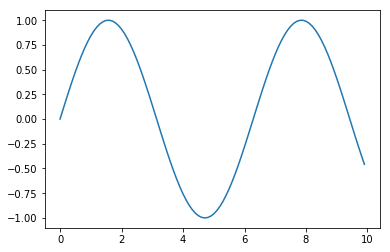

In [2]:
#plot basic sine wave
x = np.arange(0,10,.1)
y = np.sin(x)
plt.plot(x,y)
plt.show()

In [3]:
# double check function for max/min amplitude
print(np.sin(np.pi/2))
print(np.sin(-np.pi/2))

1.0
-1.0


In [4]:
# define seasonality function we will be using
# currently uses sine function, could convert to seasonality = -np.cos(x)
# where x is number of days from beg of year * 2pi / number of days in year
 


# def date_season(date):
#     year = date.year
#     min_season = pd.datetime(year,1,1)
#     max_season = pd.datetime(year,7,2)
#     dif = abs(max_season - date)
#     dif_days = dif.days
#     x = (((max_season - min_season).days) - dif.days * 2) / (max_season - min_season).days
#     seasonality = np.sin(x * (np.pi) / 2)
#     return(seasonality)

In [58]:
# line in triple quotes creates docstring for notation, must be at start of function and in triple quotes, can be multiple lines
# usually used to explain unique nature of inputs and outputs

# def date_season(date):
#     """
#     computes seasonality parameter.  date should be pd.datetime
#     """
#     year = date.year
#     max_season = pd.datetime(year,7,2) 
#     dif = date - max_season
#     dif_days = dif.days
#     day_count = (pd.datetime(year + 1, 1, 1) - pd.datetime(year, 1, 1)).days
#     x = (dif_days / (day_count)) * (2 * np.pi)
#     seasonality = np.cos(x)
#     return(seasonality)

In [113]:
def date_season(date):
    """
    computes seasonality parameter.  date should be pd.datetime
    """
    year = date.year
    max_season = pd.datetime(year,7,2) 
    dif = date - max_season
    dif_days = dif.days
    day_count = (pd.datetime(year + 1, 1, 1) - pd.datetime(year, 1, 1)).days
    seasonality = 1 - (abs(dif_days) / day_count) * 2
    return(seasonality)

In [111]:
start = dt.date(2017,1,1)
end = dt.date(2019,12,31)
df = pd.DataFrame({'Date': pd.date_range(start, end, freq="D")})
df['Seasonality'] = df.applymap(lambda x: date_season2(x))

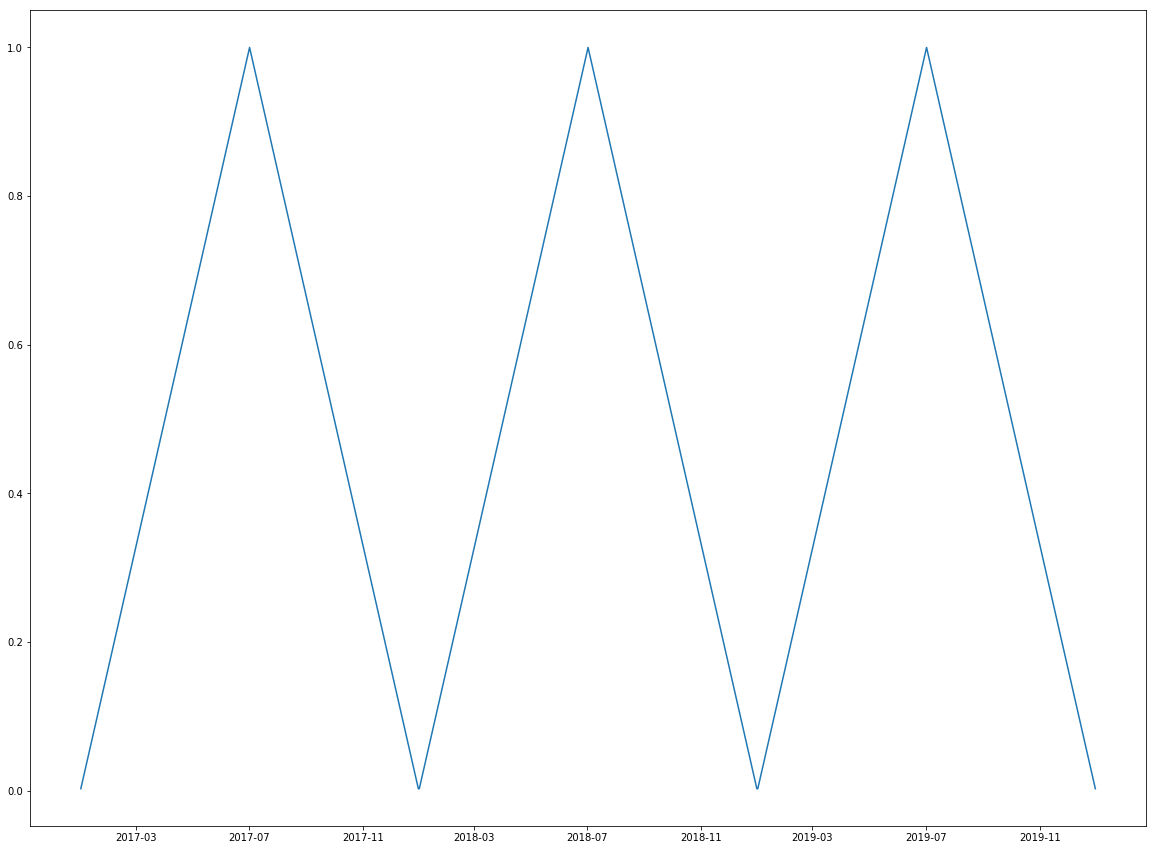

In [112]:
plt.figure(figsize=(20,15))
plt.plot(df['Date'],df['Seasonality'])

Now we need to map to calendar

In [59]:
# create pandas dataframe with a range of dates
start = dt.date(2017,1,1)
end = dt.date(2019,12,31)
df = pd.DataFrame({'Date': pd.date_range(start, end, freq="D")})

# map seasonality parameter to the range of dates
# works because there is only one column in the df we previously created, 
# will throw an error if run twice
df['Seasonality'] = df.applymap(lambda x: date_season(x))

# check to see if seasonality parameter was mapped properly
df.head()

,Date,Seasonality
0,2017-01-01,-0.999963
1,2017-01-02,-0.999667
2,2017-01-03,-0.999074
3,2017-01-04,-0.998186
4,2017-01-05,-0.997001


### In the section below, we aggregate implied volatility data into a data frame.

In [85]:
# create custom function to wrap up data cleaning work on vol csv files
# its primary purpose is to take a CSV file and convert it to only the front month vols
# doesnt need to be generalized

# add docstring for this function

def front_vol_pull(csv, min_dte, max_dte, obs_id='Observation Date',
                   vol_id='result', title_id='Stat', exp_id='exp_date0', 
                   location='C:/Users/Trader/Desktop/Dropbox/Data Science/DataSets/ImpVol/'):
    
    # read in csv file from location and csv input
    df = pd.read_csv(location+csv, index_col=False)
    
    #converts 'Observation Date' column from string to pandas datetime object
    df[obs_id] = pd.to_datetime(df[obs_id])
    
    # creates new dataframes, one with vol data and one with expiry dates
    dfvols = df.loc[df[title_id] == vol_id]
    dfexp = df.loc[df[title_id] == exp_id]
    
    # rename dat column in vol dataframe to 'Vol'
    dfvols.rename(columns={'Value':'Vol'}, inplace=True)
    
    # create truncated version of SFexp containing just the observation date and the expiry
    # promote the 'Observation Date' & 'Year' column to the multi-index of the dataframe
    # need to use multi-index to join with other dataframes
    dfexp_trunc = dfexp[[obs_id, 'Year', 'Value']]
    dfexp_trunc = dfexp_trunc.set_index([obs_id, 'Year'])
    
    # join the two dataframes on the multi-index of 'Observation Date' & 'Year'
    dfvols_exp = dfvols.join(dfexp_trunc, on=[obs_id, 'Year'])
    
    # remove 'Stat' column and rename 'Value' to 'Expiry', could be moved up a few lines
    del dfvols_exp[title_id]
    dfvols_exp.rename(columns={'Value':'Expiry'}, inplace=True)
    
    # converts 'Expiry' data to a pandas datetime object
    dfvols_exp['Expiry'] = pd.to_datetime(dfvols_exp['Expiry'])
    
    # creates new column with Days to Expiration as a timedelta
    dfvols_exp['DTE'] = dfvols_exp['Expiry'] - dfvols_exp[obs_id]
    
    # converts dte inputs to timedelta objects and creates new dataframe with filtered dates
    max_dte = pd.Timedelta(days=max_dte)
    min_dte = pd.Timedelta(days=min_dte)
    df_fronts = dfvols_exp[(dfvols_exp['DTE'] <= max_dte) & (dfvols_exp['DTE'] > min_dte)]
    
    #df_fronts.set_index(obs_id, inplace=True)
    #print(df_fronts.head())
    return df_fronts

From here, we want to use the custom front_vol_pull function on a list of csv files containing implied volatility data.

In [114]:
# create list of vol files

vol_files = ['SFvol.csv','SHvol.csv','SKvol.csv','SNvol.csv','SQvol.csv','SUvol.csv','SXvol.csv']

In [115]:
# create one large df with all data

# create a list of dataframes and concatenate them at the end of the process

full_data_set = pd.DataFrame()

tic = timeit.default_timer()

for i in vol_files:
    df = front_vol_pull(i,5,60)
    full_data_set = full_data_set.append(df)
    
toc = timeit.default_timer()
print(toc-tic)


C:\Users\Trader\Anaconda3\lib\site-packages\pandas\core\frame.py:3781: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  return super(DataFrame, self).rename(**kwargs)


39.40375499900074


In [116]:
# sort full_data_set based on DTE, drop entries with observation date overlap, keep shortest DTE
# resort by 'Observation Date' for better clarity, redefine as final_data

# try to move into grand function

full_data_set = full_data_set.sort_values('DTE').drop_duplicates('Observation Date', keep='first')
full_data_set = full_data_set.sort_values('Observation Date')

final_data = full_data_set

In [117]:
# convert values in 'Vol' column from string to float
# map seasonality value to observation date

final_data['Vol'] =  final_data['Vol'].astype(float)
final_data['Seasonality'] = final_data.apply(lambda x: date_season(x['Observation Date']), axis=1 )

In [118]:
print(len(final_data))
final_data.head()

2372


,Observation Date,Year,Vol,Expiry,DTE,Seasonality
15,2009-01-02,2009,41.439999,2009-02-20,49 days,0.008219
32,2009-01-05,2009,41.939999,2009-02-20,46 days,0.024658
49,2009-01-06,2009,43.059999,2009-02-20,45 days,0.030137
66,2009-01-07,2009,42.179999,2009-02-20,44 days,0.035616
83,2009-01-08,2009,40.659999,2009-02-20,43 days,0.041096


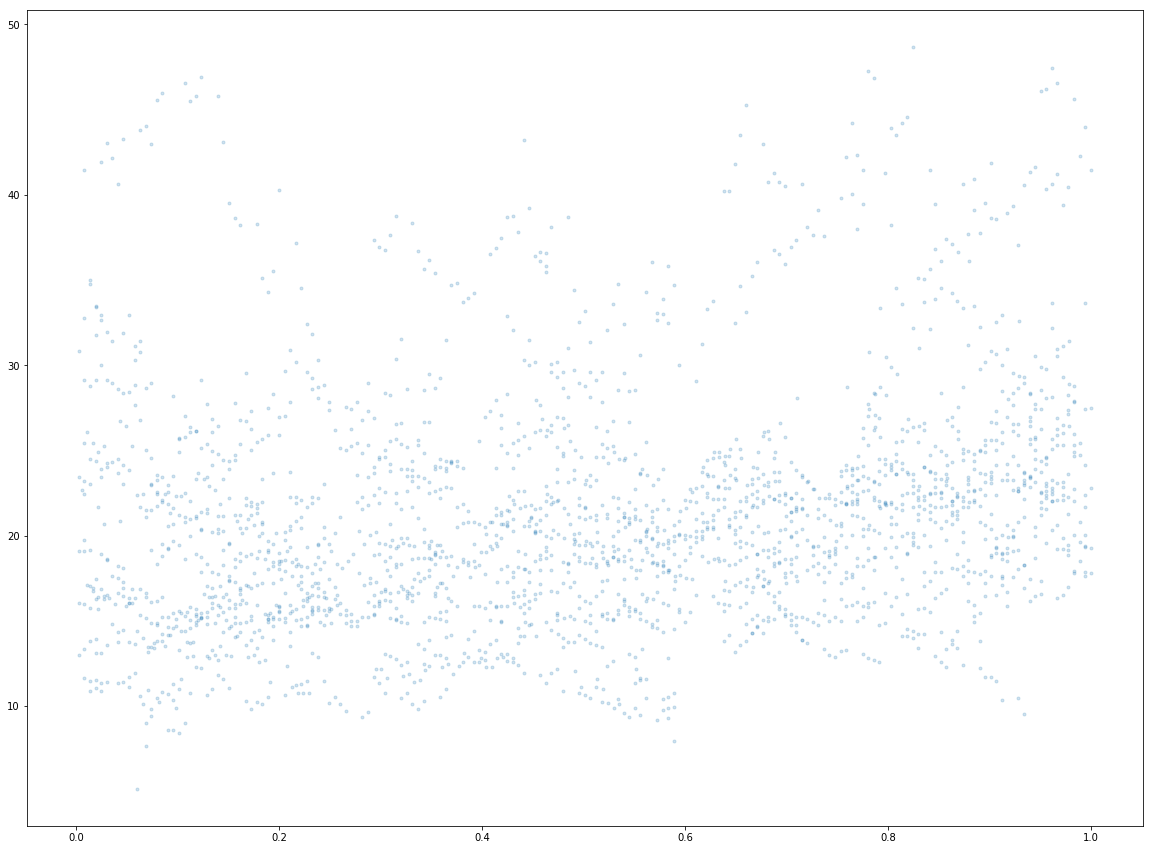

In [119]:
plt.figure(figsize=(20,15))
plt.scatter(final_data['Seasonality'], final_data['Vol'], marker='.', alpha=0.2)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000000000D0D9390>]],
      dtype=object)

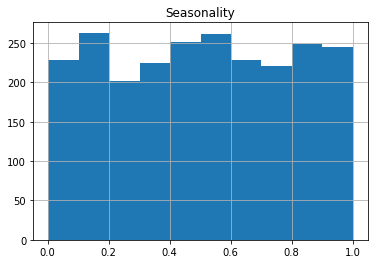

In [120]:
final_data.hist(column='Seasonality', bins=10)

Below, we attempt to fit a curve to our vol/seasonality data with a sigmoid function

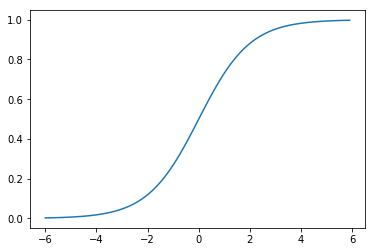

In [121]:
# create an array of numbers -6.0 to +6.0 and plot the sigmoid function using that array as input

x = np.arange(-6.0,6.0,0.1)
y = 1 / (1 + np.exp(-x))
plt.plot(x,y)

In [122]:
# define the sigmoid function that will be used in scipy.curve_fit
# this can be substituted with scipy.special.expit(x)

def sigmoid(x):
    return 1 / (1 + np.exp(-x))

In [123]:
# define our function to fit the sigmoid curve to our vol data with a k variable, min vol, and range

def sig_fit(x, k, breadth, minimum):
    return (1 / (1 + np.exp(-x*k)) * breadth) + minimum

In [124]:
print(sig_fit(0,0.5,20,10))
print(sig_fit(0,0.21,40.37,1.0))

20.0
21.185


In [144]:
xdata = final_data['Seasonality']
ydata = final_data['Vol']

#forced parameters to display nice sigmoid curve, straight line without
# the nature of seasonality sine curve might be offsetting expected result
# if seasonality was linear, the optimal curve might more reflect the sigmoid we expected
popt, pcov = curve_fit(sig_fit, xdata, ydata, bounds=([-4,-1000,-2500],[4,1000,2500]))

print(popt)
print(pcov)

[ 3.47410482e-02  6.00367801e+02 -2.81609650e+02]
[[ 1.64167823e+03 -2.83650507e+07  1.41825154e+07]
 [-2.83650507e+07  4.90093669e+11 -2.45046661e+11]
 [ 1.41825154e+07 -2.45046661e+11  1.22523244e+11]]


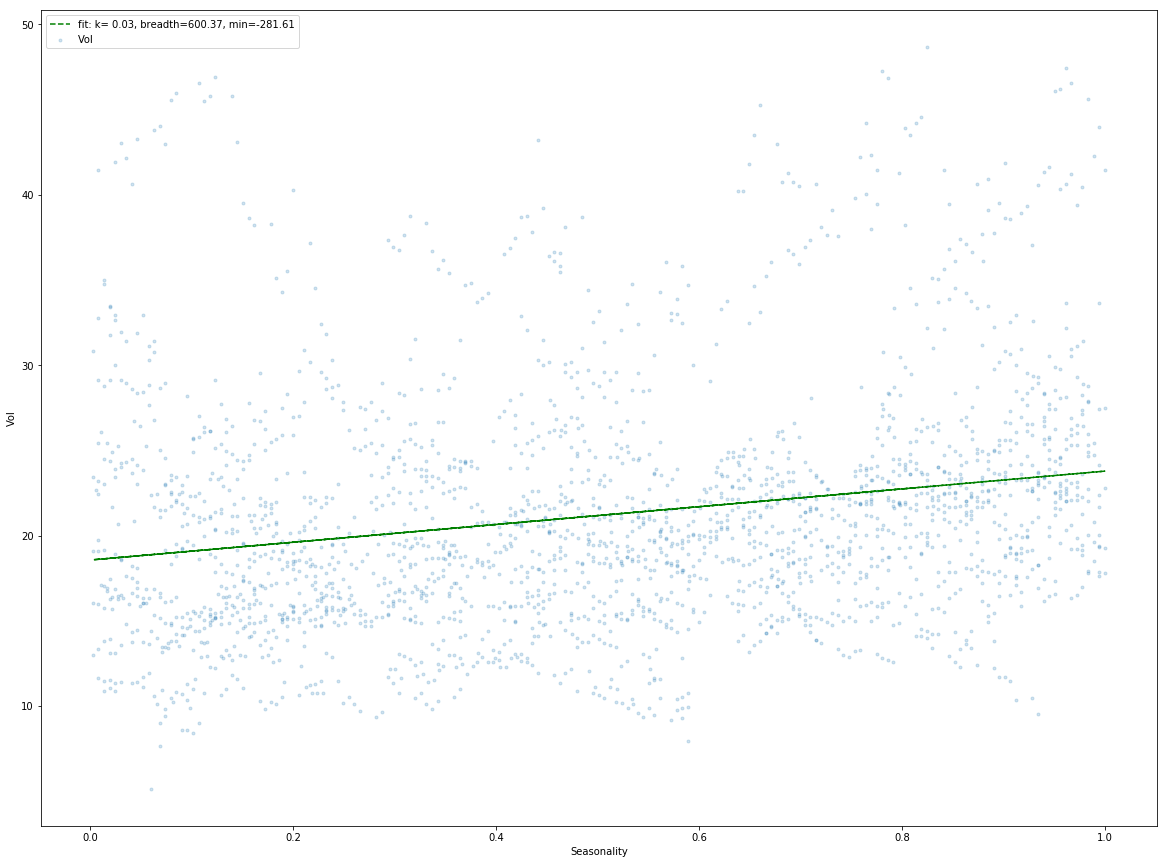

In [145]:
plt.figure(figsize=(20,15))
plt.scatter(final_data['Seasonality'], final_data['Vol'], marker='.', alpha=0.2)
plt.plot(xdata, sig_fit(xdata, *popt), 'g--', label='fit: k=%5.2f, breadth=%5.2f, min=%5.2f' % tuple(popt))
plt.ylabel('Vol')
plt.xlabel('Seasonality')
plt.legend()
plt.show()

### Creating a more reasonable model

In [127]:
print(final_data)

      Observation Date  Year        Vol     Expiry     DTE  Seasonality
15          2009-01-02  2009  41.439999 2009-02-20 49 days     0.008219
32          2009-01-05  2009  41.939999 2009-02-20 46 days     0.024658
49          2009-01-06  2009  43.059999 2009-02-20 45 days     0.030137
66          2009-01-07  2009  42.179999 2009-02-20 44 days     0.035616
83          2009-01-08  2009  40.659999 2009-02-20 43 days     0.041096
100         2009-01-09  2009  43.259999 2009-02-20 42 days     0.046575
117         2009-01-12  2009  43.779999 2009-02-20 39 days     0.063014
134         2009-01-13  2009  44.039999 2009-02-20 38 days     0.068493
151         2009-01-14  2009  42.999999 2009-02-20 37 days     0.073973
168         2009-01-15  2009  45.559999 2009-02-20 36 days     0.079452
185         2009-01-16  2009  45.959999 2009-02-20 35 days     0.084932
202         2009-01-20  2009  46.539999 2009-02-20 31 days     0.106849
219         2009-01-21  2009  45.519999 2009-02-20 30 days     0

In [128]:
recent_data = final_data[final_data['Year'] > 2014]

In [129]:
print(recent_data.head())
print(recent_data.min())
print(recent_data.max())

      Observation Date  Year        Vol     Expiry     DTE  Seasonality
22863       2014-10-27  2015  22.719999 2014-12-25 59 days     0.358904
22880       2014-10-28  2015  23.939999 2014-12-25 58 days     0.353425
22897       2014-10-29  2015  26.699999 2014-12-25 57 days     0.347945
22914       2014-10-30  2015  26.679999 2014-12-25 56 days     0.342466
22931       2014-10-31  2015  25.639999 2014-12-25 55 days     0.336986
Observation Date    2014-10-27 00:00:00
Year                               2015
Vol                                7.66
Expiry              2014-12-25 00:00:00
DTE                     6 days 00:00:00
Seasonality                  0.00273973
dtype: object
Observation Date    2019-05-29 00:00:00
Year                               2019
Vol                                32.6
Expiry              2019-06-26 00:00:00
DTE                    60 days 00:00:00
Seasonality                           1
dtype: object


In [130]:
xdata = recent_data['Seasonality']
ydata = recent_data['Vol']

popt, pcov = curve_fit(sig_fit, xdata, ydata, bounds=([0, 0, 0], [10, 40, 40]))

print(popt)
print(pcov)

[9.39990485e-01 2.87083014e+01 5.17293418e-12]
[[   1.6025628   -43.05119846   21.23905349]
 [ -43.05119846 1160.61037531 -573.05634428]
 [  21.23905349 -573.05634428  283.02119026]]


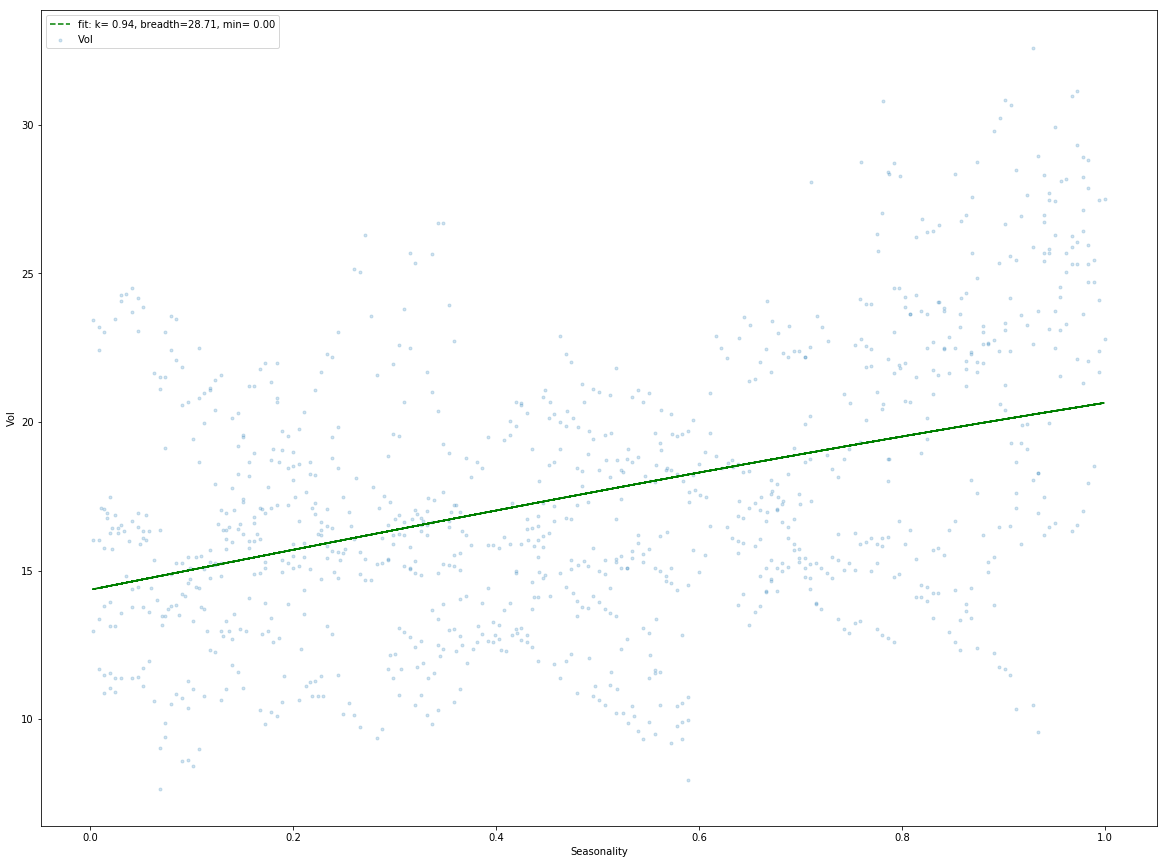

In [131]:
plt.figure(figsize=(20,15))
plt.scatter(recent_data['Seasonality'], recent_data['Vol'], marker='.', alpha=0.2)
plt.plot(xdata, sig_fit(xdata, *popt), 'g--', label='fit: k=%5.2f, breadth=%5.2f, min=%5.2f' % tuple(popt))
plt.ylabel('Vol')
plt.xlabel('Seasonality')
plt.legend()
plt.show()

Despite limiting the data to the most recent 5 years, we still see a very linear relationship between seasonality and implied volatility

Below we attepmt to fit an arc tangent function

In [132]:
def arc_fit(x, k, breadth, minimum):
    return (np.arctan(x*k) * breadth) + minimum

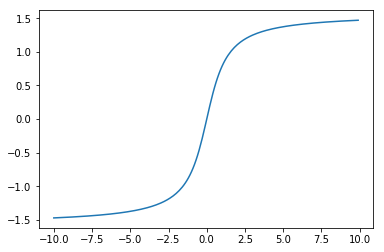

In [133]:
x = np.arange(-10,10,.1)
y = np.arctan(x)
plt.plot(x,y)
plt.show()

In [134]:
print(arc_fit(3.14/2,1,1,0))
print(arc_fit(0.5,1,10,0))

1.0036550779803273
4.636476090008061


In [135]:
popt, pcov = curve_fit(arc_fit, xdata, ydata, bounds=([0, 0, 0], [10, 40, 50]))

print(popt)
print(pcov)

[ 0.17045669 39.99999993 14.21218386]
[[ 2.37167886e+00 -5.47164274e+02 -3.42174318e-01]
 [-5.47164274e+02  1.26241853e+05  7.83743341e+01]
 [-3.42174318e-01  7.83743341e+01  1.12760189e-01]]


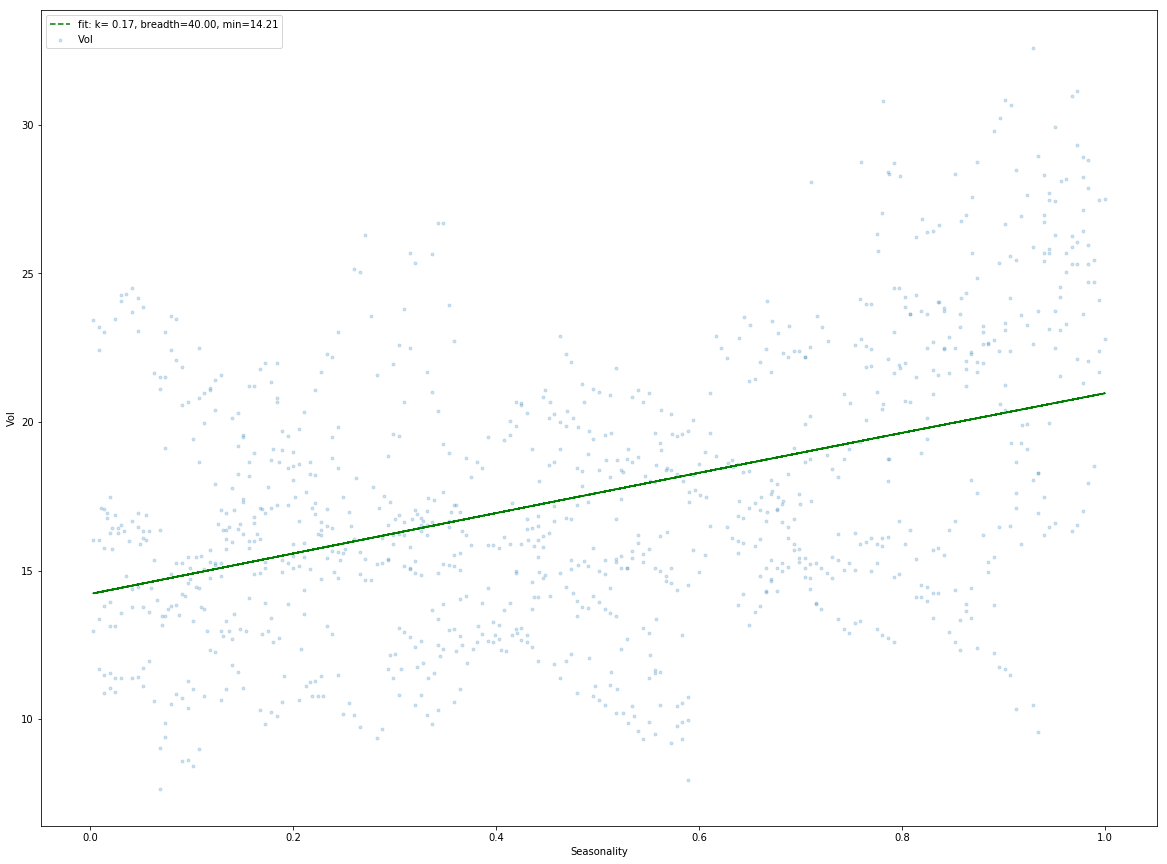

In [136]:
plt.figure(figsize=(20,15))
plt.scatter(recent_data['Seasonality'], recent_data['Vol'], marker='.', alpha=0.2)
plt.plot(xdata, arc_fit(xdata, *popt), 'g--', label='fit: k=%5.2f, breadth=%5.2f, min=%5.2f' % tuple(popt))
plt.xlabel('Seasonality')
plt.ylabel('Vol')
plt.legend()
plt.show()

In [137]:
recent_data.describe()

,Year,Vol,DTE,Seasonality
count,1045.000000,1045.000000,1045,1045.000000
mean,2016.813397,17.498861,31 days 03:47:22.105263,0.484326
std,1.343571,4.622618,15 days 18:03:13.608213,0.291271
min,2015.000000,7.660000,6 days 00:00:00,0.002740
25%,2016.000000,14.360000,18 days 00:00:00,0.221918
50%,2017.000000,16.600000,30 days 00:00:00,0.475410
75%,2018.000000,20.660000,45 days 00:00:00,0.742466
max,2019.000000,32.599999,60 days 00:00:00,1.000000


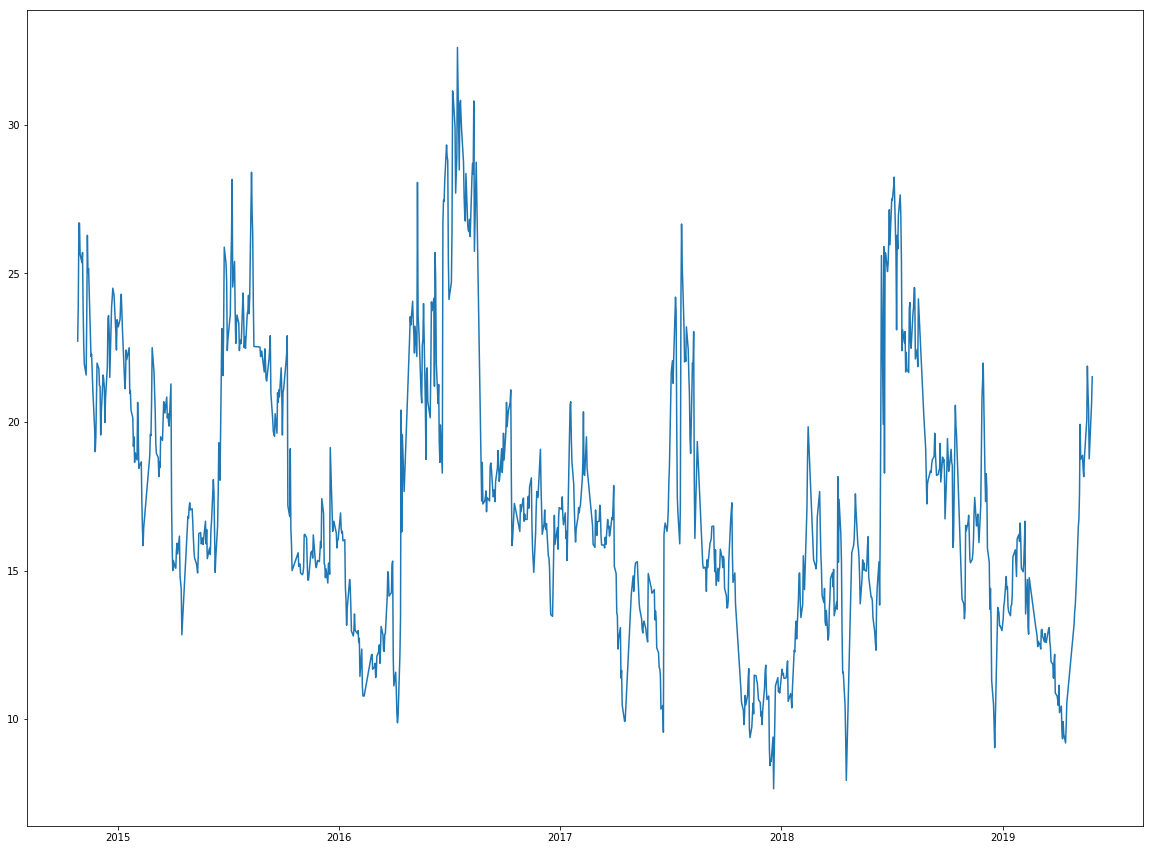

In [138]:
plt.figure(figsize=(20,15))
plt.plot(recent_data['Observation Date'],recent_data['Vol'])

In [139]:
print(len(recent_data))

1045


In [140]:
print(recent_data[750:800])

      Observation Date  Year    Vol     Expiry     DTE  Seasonality
37381       2018-02-05  2018  13.86 2018-02-20 15 days     0.194521
37398       2018-02-06  2018  15.50 2018-02-20 14 days     0.200000
37415       2018-02-08  2018  14.36 2018-02-20 12 days     0.210959
37432       2018-02-09  2018  15.06 2018-02-20 11 days     0.216438
37449       2018-02-12  2018  17.08 2018-02-20  8 days     0.232877
37466       2018-02-13  2018  18.78 2018-02-20  7 days     0.238356
37483       2018-02-14  2018  19.84 2018-02-20  6 days     0.243836
37636       2018-02-23  2018  15.36 2018-04-24 60 days     0.293151
37653       2018-02-26  2018  15.16 2018-04-24 57 days     0.309589
37670       2018-02-27  2018  15.06 2018-04-24 56 days     0.315068
37687       2018-02-28  2018  15.32 2018-04-24 55 days     0.320548
37704       2018-03-01  2018  16.78 2018-04-24 54 days     0.326027
37721       2018-03-02  2018  17.00 2018-04-24 53 days     0.331507
37738       2018-03-05  2018  17.66 2018-04-24 5

In [147]:
year_range = range(2014,2019)
df_by_year = []
for year in year_range:
    data = final_data[final_data['Year'] == year]
    df_by_year.append(data)

In [149]:
year_range = range(2014, 2019)
df_by_year = [final_data[final_data['Year'] == year] for year in year_range]

In [150]:
df_by_year

[      Observation Date  Year        Vol     Expiry     DTE  Seasonality
 18647       2013-10-28  2014  18.340000 2013-12-26 59 days     0.353425
 18664       2013-10-29  2014  17.980000 2013-12-26 58 days     0.347945
 18681       2013-10-30  2014  17.520000 2013-12-26 57 days     0.342466
 18698       2013-10-31  2014  17.800000 2013-12-26 56 days     0.336986
 18715       2013-11-01  2014  18.620000 2013-12-26 55 days     0.331507
 18732       2013-11-04  2014  18.340000 2013-12-26 52 days     0.315068
 18749       2013-11-05  2014  18.740000 2013-12-26 51 days     0.309589
 18766       2013-11-06  2014  18.540000 2013-12-26 50 days     0.304110
 18783       2013-11-07  2014  18.940000 2013-12-26 49 days     0.298630
 18800       2013-11-08  2014  15.880000 2013-12-26 48 days     0.293151
 18817       2013-11-11  2014  15.020000 2013-12-26 45 days     0.276712
 18834       2013-11-12  2014  15.020000 2013-12-26 44 days     0.271233
 18851       2013-11-13  2014  15.340000 2013-12-26

In [160]:
max_by_year = []
for i in df_by_year:
    stuff = i['Vol'].idxmax()
    max_by_year.append(i.loc[stuff])
print(max_by_year)

[Observation Date    2014-10-15 00:00:00
Year                               2014
Vol                                28.3
Expiry              2014-10-24 00:00:00
DTE                     9 days 00:00:00
Seasonality                    0.424658
Name: 23339, dtype: object, Observation Date    2015-08-10 00:00:00
Year                               2015
Vol                                28.4
Expiry              2015-08-21 00:00:00
DTE                    11 days 00:00:00
Seasonality                    0.786301
Name: 22132, dtype: object, Observation Date    2016-07-15 00:00:00
Year                               2016
Vol                                32.6
Expiry              2016-07-24 00:00:00
DTE                     9 days 00:00:00
Seasonality                    0.928962
Name: 26688, dtype: object, Observation Date    2017-07-20 00:00:00
Year                               2017
Vol                               26.66
Expiry              2017-08-21 00:00:00
DTE                    32 days 00:0